# Text Experiments
---
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
---
## Summary

Experiments for the text-only sentiment analysis models. We are trying the following models:
- [SVC](#svc)
- [Logistic Regression](#logistic-regression)
- [Naive Bayes](#naive-bayes)
    - [Multinomial](#multinomial-nb)
    - [Compliment](#compliment-nb)
- [One vs. Rest](#one-vs-rest)
- [FFNN](#ffnn)
- [LSTM](#lstm)

For SVC, Logistic Regression, and both Naive Bayes (which will only accept string inputs and outputs) we will experiment with the following:
- Count Vectors
- TF-IDF Vectors
- Gensim Custom Doc2Vec Vectors
- Gensim Custom Doc2Vec Vectors with SMOTE

For FFNN and LSTM
- Gensim word2vec Vectors via [GoogleNews](https://code.google.com/archive/p/word2vec/)
- Gensim word2vec Vectors via [GoogleNews](https://code.google.com/archive/p/word2vec/) with SMOTE
---
## Setup
### Necessary Imports
#### Experiment Class & Metrics

In [1]:
from experiment import (Experiment,
                        plot_confusion_matrix,
                        vectorizer, )

from sklearn.metrics import (accuracy_score,
                             precision_recall_fscore_support,
                             confusion_matrix, )

#### Models

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import (MultinomialNB,
                                 ComplementNB, )
from sklearn.svm import SVC

#### Other

In [3]:
from gensim.models import KeyedVectors
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer, )

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Global Variables & Settings

In [4]:
DATA_PATH = "../data/final-splits.csv"
DATA = pd.read_csv(DATA_PATH, index_col=False)
EMOTIONS = DATA.emotion.unique()

SEED = 42

METRICS = {"accuracy": (accuracy_score, {}),
           "precision_recall_fscore_support": (precision_recall_fscore_support, {"average": "macro", "zero_division": np.nan}),
           "confusion_matrix": (confusion_matrix, {"labels": EMOTIONS}), }

# Only run the experiments listed here; empty means run all
targets = []
def selected(target):
    if target in targets or len(targets) == 0:
        return True
    return False

In [5]:
WTESTS = False  # Include and load word2vec experiments

if WTESTS:
    WORD2VEC_PATH = "../data/word2vec/GoogleNews-vectors-negative300.bin"
    W2V: KeyedVectors = KeyedVectors.load_word2vec_format(WORD2VEC_PATH, binary=True)

STOPWORDS = stopwords.words()

### Functions

In [6]:
def default_vector(name: str):

    if name == "count":
        return CountVectorizer(stop_words="english", max_features=1_000)
    elif name == "tfidf":
        return TfidfVectorizer(stop_words="english", max_features=1_000) 

In [7]:
def display_results(metrics):

    print(f"Accuracy: {metrics['accuracy']:.3f}")
    
    prec, recall, f1, _ = metrics['precision_recall_fscore_support']

    print(f"Precision: {prec:.3f}")
    print(f"Recall: {prec:.3f}")
    print(f"F1-Score: {prec:.3f}")

    plot_confusion_matrix(metrics['confusion_matrix'], labels=EMOTIONS)

In [8]:
def w2v_transform(X, y, subset):
    return [[W2V[word] for word in word_tokenize(sent) if word not in STOPWORDS] for sent in X], y

***
## SVC

In [9]:
EXP1A = "SVC/COUNT"

def exp1a():

    exp = Experiment(name=EXP1A, data=DATA, model=SVC(C=1))
    exp.transform(vectorizer, vect=default_vector("count"))
    results = exp.full_run(metrics=METRICS)
    display_results(results)

Accuracy: 0.539
Precision: 0.577
Recall: 0.577
F1-Score: 0.577


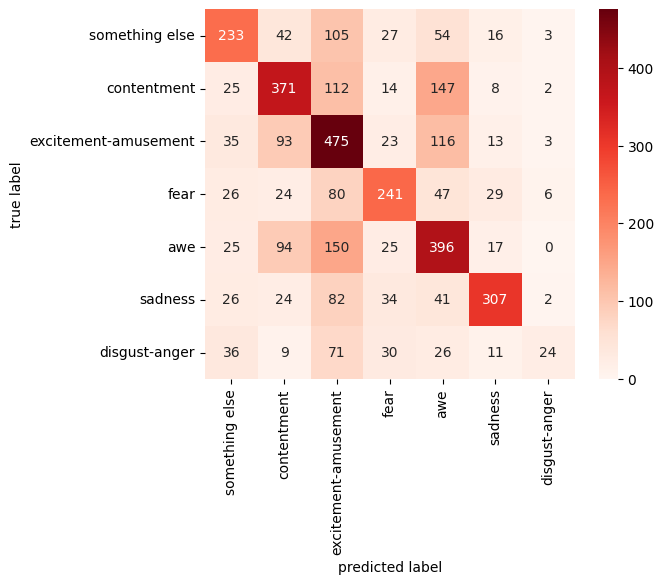

In [10]:
if selected(EXP1A):
    exp1a()

In [11]:
EXP1B = "SVC/TFIDF"

def exp1b():

    exp = Experiment(name=EXP1B, data=DATA, model=SVC())
    exp.transform(vectorizer, vect=default_vector("tfidf"))
    results = exp.full_run(metrics=METRICS)
    display_results(results)

Accuracy: 0.556
Precision: 0.578
Recall: 0.578
F1-Score: 0.578


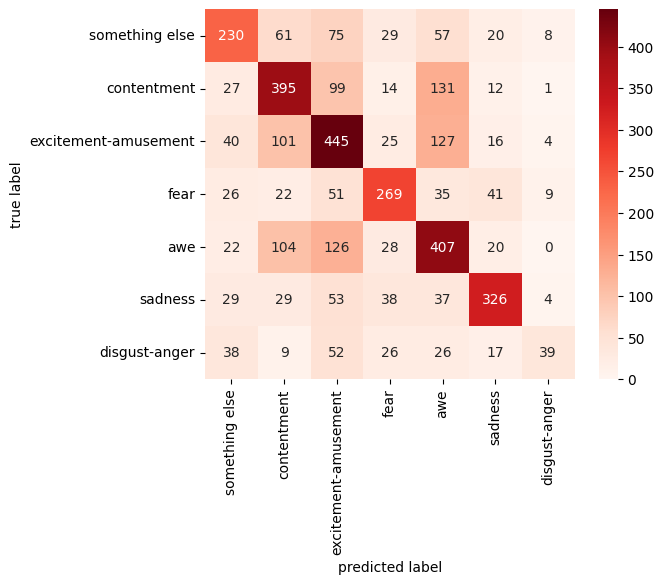

In [12]:
if selected(EXP1B):
    exp1b()

***
## Logistic Regression

In [13]:
EXP2A = "LOG/COUNT"

def exp2a():

    exp = Experiment(name=EXP2A, data=DATA, model=LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5))
    exp.transform(vectorizer, vect=default_vector("count"))
    results = exp.full_run(metrics=METRICS)
    display_results(results)

/home/computer_cat/miniconda3/envs/deep_learning/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.566
Precision: 0.569
Recall: 0.569
F1-Score: 0.569


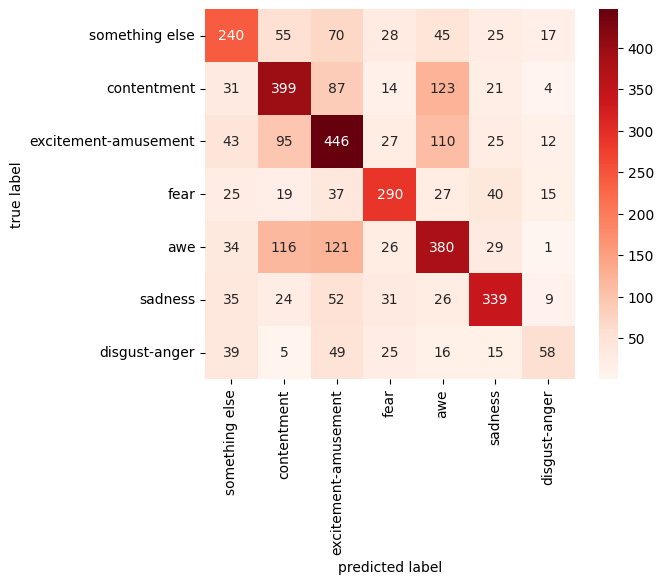

In [14]:
if selected(EXP2A):
    exp2a()

In [15]:
EXP2B = "LOG/TFIDF"

def exp2b():

    exp = Experiment(name=EXP2B, data=DATA, model=LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5))
    exp.transform(vectorizer, vect=default_vector("tfidf"))
    results = exp.full_run(metrics=METRICS)
    display_results(results)

Accuracy: 0.567
Precision: 0.574
Recall: 0.574
F1-Score: 0.574


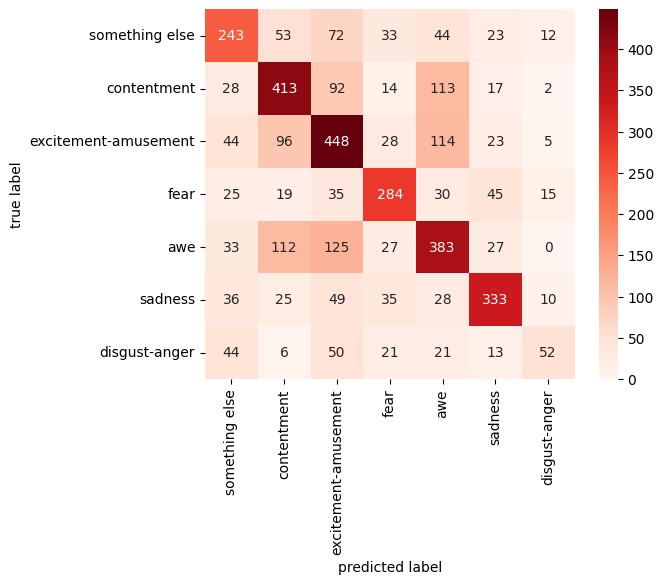

In [16]:
if selected(EXP2B):
    exp2b()

***
## Naive Bayes
### Multinomial NB

In [17]:
EXP3A = "MNB/COUNT"

def exp3a():

    exp = Experiment(name=EXP3A, data=DATA, model=MultinomialNB())
    exp.transform(vectorizer, vect=default_vector("count"))
    results = exp.full_run(metrics=METRICS)
    display_results(results)

Accuracy: 0.571
Precision: 0.569
Recall: 0.569
F1-Score: 0.569


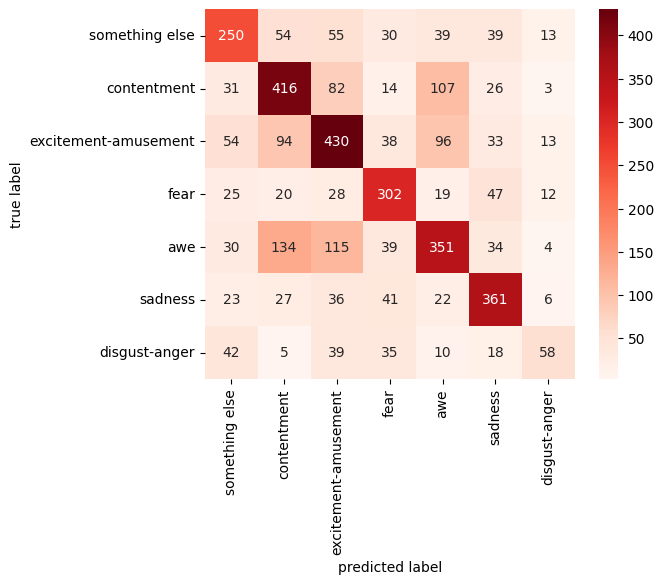

In [18]:
if selected(EXP3A):
    exp3a()

In [19]:
EXP3B = "MNB/TFIDF"

def exp3b():

    exp = Experiment(name=EXP3A, data=DATA, model=MultinomialNB())
    exp.transform(vectorizer, vect=default_vector("tfidf"))
    results = exp.full_run(metrics=METRICS)
    display_results(results)

Accuracy: 0.561
Precision: 0.596
Recall: 0.596
F1-Score: 0.596


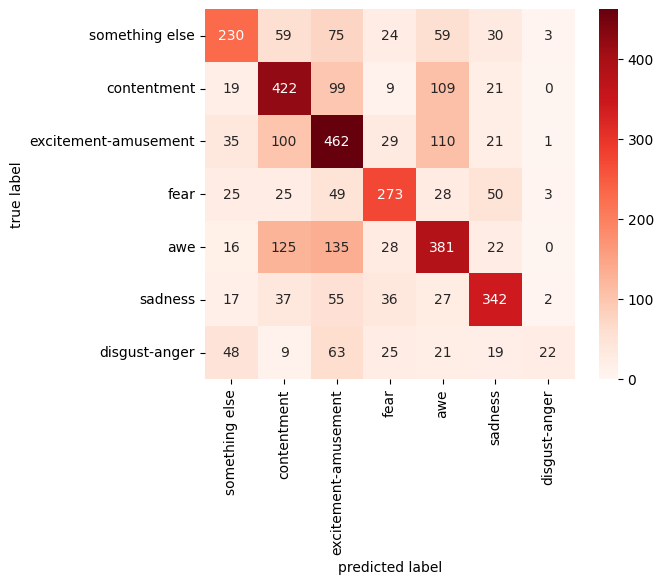

In [20]:
if selected(EXP3B):
    exp3b()

### Compliment NB

In [21]:
EXP4A = "COM/COUNT"

def exp4a():

    exp = Experiment(name=EXP4A, data=DATA, model=ComplementNB())
    exp.transform(vectorizer, vect=default_vector("count"))
    results = exp.full_run(metrics=METRICS)
    display_results(results)

Accuracy: 0.567
Precision: 0.559
Recall: 0.559
F1-Score: 0.559


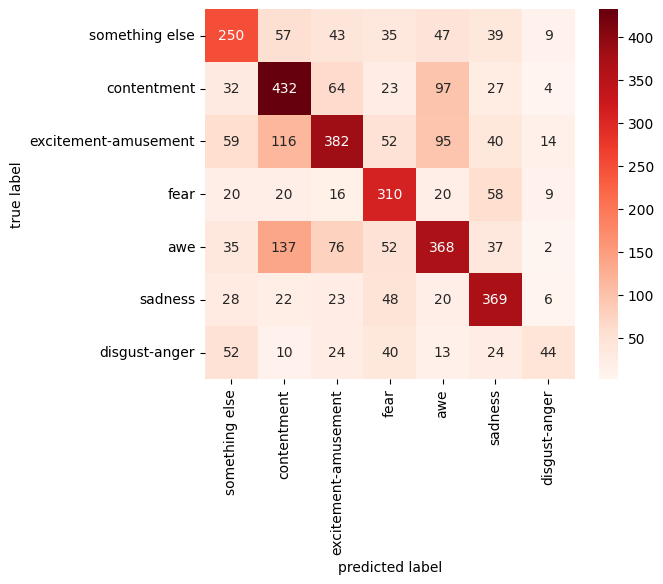

In [22]:
if selected(EXP4A):
    exp4a()

In [23]:
EXP4B = "COM/TFIDF"

def exp4b():

    exp = Experiment(name=EXP4B, data=DATA, model=ComplementNB())
    exp.transform(vectorizer, vect=default_vector("tfidf"))
    results = exp.full_run(metrics=METRICS)
    display_results(results)

Accuracy: 0.567
Precision: 0.556
Recall: 0.556
F1-Score: 0.556


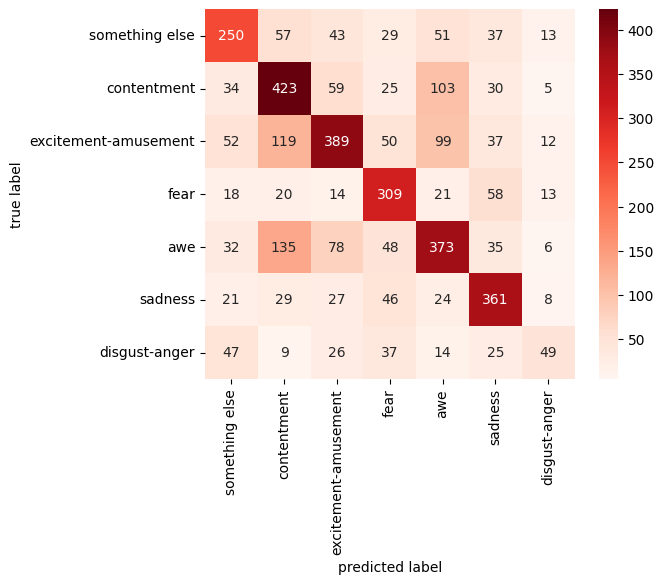

In [24]:
if selected(EXP4B):
    exp4b()

***
## One Vs. Rest

For this, we will only run the best of the non-NN models.

In [25]:
EXP5A = "ONE"

def exp5a():

    exp = Experiment(name=EXP5A, data=DATA, model=OneVsRestClassifier(SVC(C=1)))
    exp.transform(vectorizer, vect=default_vector("tfidf"))
    results = exp.full_run(metrics=METRICS)
    display_results(results)

Accuracy: 0.574
Precision: 0.568
Recall: 0.568
F1-Score: 0.568


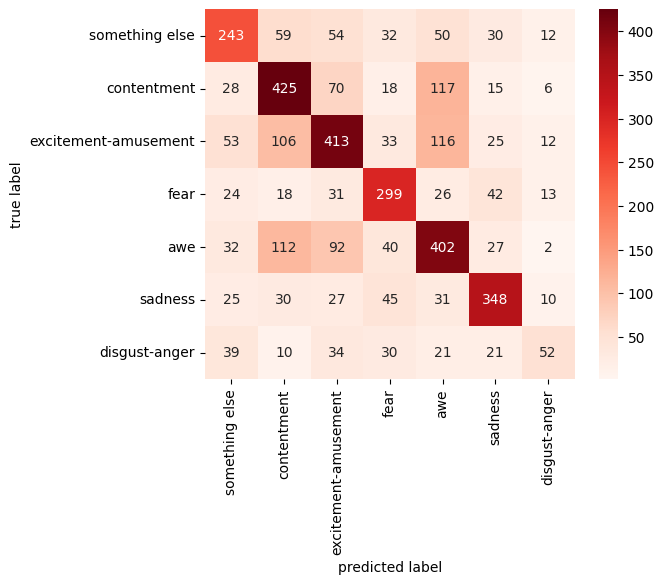

In [26]:
if selected(EXP5A):
    exp5a()

***
## FFNN

***
## LSTM